# Imports

In [1001]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from src.visualization.visualize import plot_confusion_matrix
from atomm.Tools import calc_open_position

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [911]:
# Load environment variables
load_dotenv(find_dotenv())

True

In [1139]:
fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')

In [912]:
# Load dataset from pickle file
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname = data_base_dir + '/processed/djia_cleaned_2019-12-11.pkl'
djia = pickle.load(open(fname, 'rb'))

In [1369]:
symbol_list = djia.columns.get_level_values(0).unique()

In [1370]:
#MomentumIndicators(MSDataManager().ReturnData('AAPL', limit=100)['Close']).calcMACD(12, 26,)

In [1371]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]

# Target variable

## Forecast Horizon

The target of this project is to forecast future price movements of a given asset based on the different technical indicators. Technical indicators are mathematical formulas intended which reflect the past price movements. It is assumed that history will (at least partially) be repeated in the future.

In order to build a supervised machine learning model, we need a target variable. Here, we will use two different classifications for predicting the future price trend: A two label classification scheme (1: up, 0: down), and a three label classification scheme (1: up; 0: no movement; -1: down). In both cases, the relative future price change is used to label the training and test data set:
$$y(t)=\frac{C_{t+n}-C_t}{C_t}$$


### Two-class classification

For the two label classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt 0$ }\\0, & \text{if $ y(t)\lt 0$ } \\\end{cases}$$

In [1031]:
 for n in forecast_horizon:
            #diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            #signal = np.where(diff > 0, 1, 0)
            dicti['CNC'][f'_signal_{n}'] = 1

In [1339]:
def create_two_class_signal(df, symbol_list):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    sign_dic = {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti = {}
        for n in forecast_horizon:
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal = np.where(diff > 0, 1, 0)
            dicti[f'signal_{n}'] = signal
        sign_df = pd.DataFrame.from_dict(dicti)
        sign_dic[symbol] = sign_df
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    return df_signals

In [1340]:
#dicti = {}
y_2c = create_two_class_signal(djia, symbol_list)
#y_2c = pd.DataFrame(dict_of_df)

### Calculate percentage of data points assigned to each class

In [1317]:
l1 = []
for y in y_2c.columns.get_level_values(0).unique():
    l = []
    for x in y_2c[y].columns:
        c = y_2c[y][x].value_counts()
        s = c[0] + c[1]
        l.append([c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['0', '1']), columns=y_2c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
0,0.474747,0.458203,0.450377,0.446028,0.439414,0.431708,0.426842,0.421847,0.417011
1,0.525253,0.541797,0.549623,0.553972,0.560586,0.568292,0.573158,0.578153,0.582989


### Plot signals and open positions

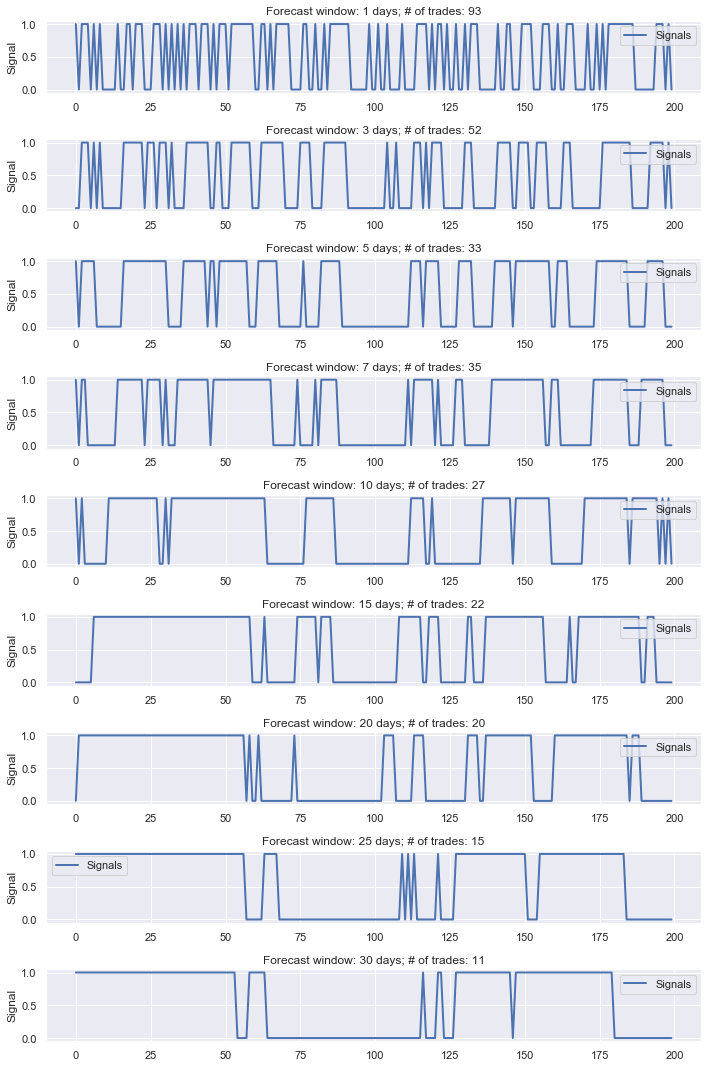

In [1144]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
for i, n in enumerate(forecast_horizon):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(y_2c['IBM'][f'signal_{n}'][:window], lw=2, label='Signals')
    #plt.plot(y_3c[f'AAPL_open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_2c['IBM'][f'signal_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

### Three class classification

For the three class classification, the labels are calculated as follows

$$l(t)=\begin{cases}1, & \text{if $ y(t)\gt \delta$ }\\0, & \text{if $-\delta \leq y(t)\leq \delta$ } \\-1, & \text{if $ y(t)\lt -\delta$ }\end{cases}$$

where the threshold $\delta$ is a parameter of the strategy that needs tuning.

In [1437]:
threshold_list = [0.63, 1.15, 1.49, 1.79, 2.14, 2.65, 3.08, 3.48, 3.94]

In [1463]:
def create_three_class_signal(df, symbol_list, threshold=None, multi=1):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    df_op = df_signals.copy()
    sign_dic, op_dic = {}, {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti, dict_op = {}, {}
        for n, thresh in zip(forecast_horizon, threshold):
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal1p = np.where(diff > multi*thresh/100, 1, 0)
            signal1n = np.where(diff < -multi*thresh/100, -1, 0)
            signal = signal1p + signal1n
            open_position = calc_open_position(signal)
            dicti[f'signal_{n}'] = signal
            dict_op[f'open_position_{n}'] = open_position
        sign_dic[symbol] = pd.DataFrame.from_dict(dicti)
        op_dic[symbol] = pd.DataFrame.from_dict(dict_op)
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    df_op = pd.concat(op_dic.values(), keys=op_dic.keys(), axis=1)
    return df_signals, df_op

In [1464]:
#dicti = {}
y_3c, y_3op = create_three_class_signal(djia, symbol_list, threshold=threshold_list)


### Calculate percentage of data points assigned to each class

In [1465]:
l1 = []
for y in y_3c.columns.get_level_values(0).unique():
    l = []
    for x in y_3c[y].columns:
        c = y_3c[y][x].value_counts()
        s = c[0] + c[1] + c[-1]
        l.append([c[-1]/s, c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['-1', '0', '1']), columns=y_3c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
-1,0.266236,0.254697,0.251927,0.247756,0.242016,0.236356,0.232701,0.227845,0.217944
0,0.424707,0.428153,0.419047,0.419791,0.417329,0.413714,0.407448,0.405730,0.417130
1,0.309057,0.317150,0.329027,0.332453,0.340655,0.349930,0.359851,0.366425,0.364926


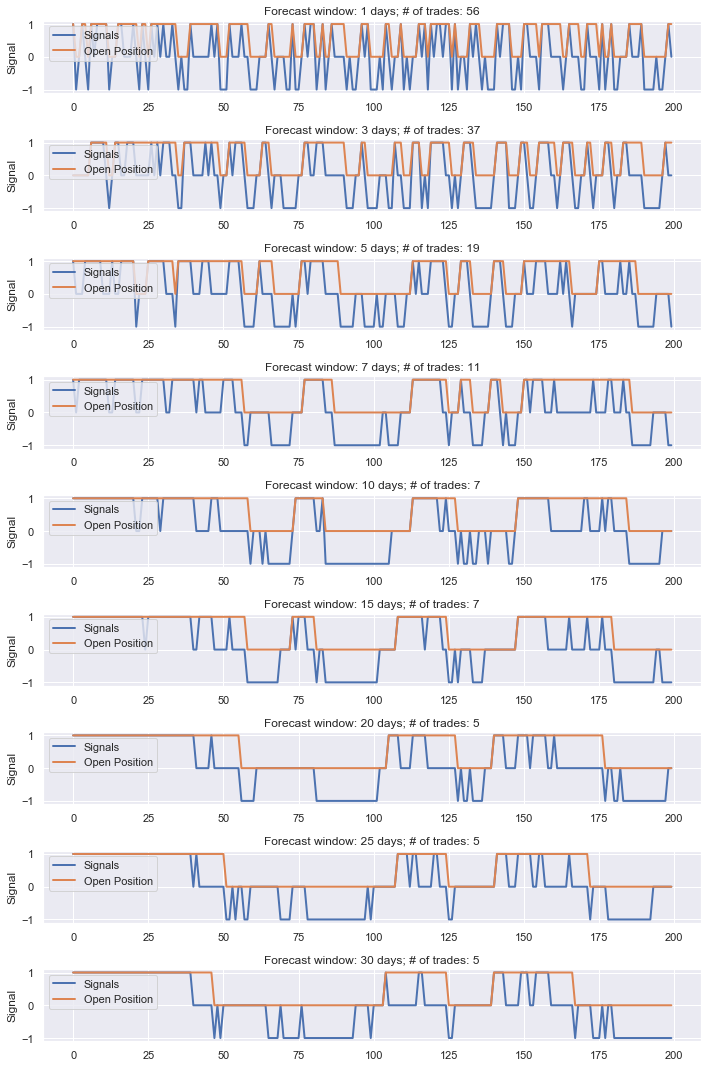

In [1461]:
plt.figure(figsize=(10, 15))
colors = ['black', 'red', 'green', 'blue']
window = 200
for i, n in enumerate(input_n):
    plt.subplot(len(input_n), 1, i+1)
    plt.plot(y_3c['MSFT'][f'signal_{n}'][:window], lw=2, label='Signals')
    plt.plot(y_3op['MSFT'][f'open_position_{n}'][:window], label='Open Position', lw=2,)
    plt.legend()
    plt.tight_layout()
    plt.ylabel('Signal')
    num_of_trades = int(y_3op['MSFT'][f'open_position_{n}'][:window].diff().abs().sum())
    plt.title(f'Forecast window: {n} days; # of trades: {num_of_trades}')
plt.show()

In [925]:
input_n

[1, 3, 5, 7, 10, 15, 20, 25, 30]

In [926]:
y = signals_true

In [927]:
y.head()

,index,AAPL_signal_3,AAPL_signal_5,AAPL_signal_7,AAPL_signal_10,AAPL_signal_15,AAPL_signal_20,AAPL_signal_25,AAPL_signal_30
0,0,0,-1,-1,0,0,-1,-1,-1
1,1,0,-1,-1,0,0,-1,-1,-1
2,2,0,-1,0,0,0,-1,0,0
3,3,-1,-1,0,0,-1,0,-1,0
4,4,-1,0,0,0,0,0,-1,0


In [928]:
y.reset_index(inplace=True)

# Feature Engineering

Input window length:
[3, 5, 7, 10, 15, 20, 25, 30]

1. MACD x
2. RSI x
3. ROC x
4. BB x
5. SMA x
6. EMA x
7. ATR x
8. ADX x
9. CCI x
10. WILLIAMSR x
11. STOCK_n x
12. STOCD EMA_n(STOCK) x

In [929]:
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
def calcIndicators(data, symbol):
    mi = MomentumIndicators(data[symbol])
    df = pd.DataFrame(index=data.index)
    for n in input_window_size:
        # 1) MACD 
        df[f'{symbol}_macd_{n}'] = mi.calcMACD(n, 2*n)
        # 2) RSI
        df[f'{symbol}_rsi_{n}'] = mi.calcRSI(n)
        # 3) STOC
        df[f'{symbol}_stoc_{n}'] = mi.calcSTOC(n)
        # 4) ROC
        df[f'{symbol}_roc_{n}'] = mi.calcROC(n)
        # 5) Bollinger Bands
        df[f'{symbol}_bbu_{n}'], df[f'{symbol}_bbl_{n}'] = mi.calcBB(n)
        # 6) EMA
        df[f'{symbol}_ema_{n}'] = mi.calcEMA(n)
        # 7) ATR
        df[f'{symbol}_atr_{n}'] = mi.calcATR(n)
        # 8) ADX
        df[f'{symbol}_adx_{n}'] = mi.calcADX(n)
        # 9) CCI
        df[f'{symbol}_cci_{n}'] = mi.calcCCI(n)
        # 10) WilliamsR
        df[f'{symbol}_williamsr_{n}'] = mi.calcWR(n)
        # 11) STOCD
        df[f'{symbol}_stocd_{n}'] = mi.calcEMA(n, df[f'{symbol}_stoc_{n}'])
    return df

In [930]:
X = calcIndicators(djia, 'AAPL')

/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:129: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:108: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/robin/Documents/temp/atomm/src/atomm/Indicators.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [931]:
X.tail()

,AAPL_macd_3,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
Epoch,,,,,,,,,,,,,,,,,,,,,
2019-11-27 00:00:00+00:00,0.949406,79.647823,100.000000,0.023149,271.407410,264.272583,266.106173,4.336670,30.354829,100.000000,...,100.000000,0.142808,288.530754,247.149239,254.942100,3.824665,34.275236,90.304217,0.464048,94.823906
2019-11-29 00:00:00+00:00,0.923253,57.074028,83.380328,0.003304,271.054564,263.445436,266.678086,3.483337,33.265621,50.209146,...,98.122824,0.135881,286.987788,247.512212,255.736158,3.806999,34.397893,87.604865,2.224859,95.036740
2019-12-02 00:00:00+00:00,0.119877,49.100932,0.000000,-0.000492,268.112937,260.207071,265.419045,3.529999,19.402720,-100.000000,...,86.800595,0.117381,282.626653,245.693354,256.279632,3.857331,32.536081,71.969522,13.197792,94.505376
2019-12-03 00:00:00+00:00,-1.193452,0.000000,0.000000,-0.031325,267.305877,251.594148,262.434529,3.869995,29.695304,-100.000000,...,69.906789,0.078749,276.834267,242.065758,256.484172,3.861664,33.016843,10.273487,28.396212,92.918370
2019-12-04 00:00:00+00:00,-1.001295,22.695597,48.619579,-0.020617,266.450580,257.029400,262.087259,4.456655,20.276281,1.062958,...,75.263564,0.090765,277.825339,245.654642,256.823257,3.904330,31.587192,38.818693,21.006804,91.779350


In [932]:
X.describe()

,AAPL_macd_3,AAPL_rsi_3,AAPL_stoc_3,AAPL_roc_3,AAPL_bbu_3,AAPL_bbl_3,AAPL_ema_3,AAPL_atr_3,AAPL_adx_3,AAPL_cci_3,...,AAPL_stoc_30,AAPL_roc_30,AAPL_bbu_30,AAPL_bbl_30,AAPL_ema_30,AAPL_atr_30,AAPL_adx_30,AAPL_cci_30,AAPL_williamsr_30,AAPL_stocd_30
count,1259.000000,1256.000000,1258.000000,1256.000000,1258.000000,1258.000000,1259.000000,1259.000000,1258.000000,1258.000000,...,1258.000000,1229.000000,1258.000000,1258.000000,1259.000000,1259.000000,1258.000000,1258.000000,1259.000000,1258.000000
mean,0.176647,54.900666,54.978335,0.002345,155.154878,149.013262,151.938565,2.912793,35.661170,9.389570,...,61.864806,0.025058,162.127061,142.041079,150.427258,2.898911,36.386338,29.118303,38.592255,60.806936
std,1.246807,34.388148,45.092480,0.026924,42.696012,40.973391,41.606114,1.618553,18.940392,80.153442,...,34.861399,0.090580,45.125115,38.997116,39.693827,1.201926,11.383475,113.143039,30.850640,23.656750
min,-5.113457,0.000000,0.000000,-0.103382,92.928516,85.093086,91.063328,0.000000,2.539166,-100.000000,...,0.000000,-0.295746,96.604255,74.698124,96.220068,0.000000,18.716978,-302.110322,0.000000,0.000000
25%,-0.439365,26.282627,0.000000,-0.012345,116.966869,112.367167,114.528497,1.803337,20.846431,-81.105711,...,30.504453,-0.027194,121.500409,108.302533,114.145912,2.023833,28.474194,-56.214245,10.286618,44.210391
50%,0.232191,57.323018,69.671622,0.002807,150.833111,144.340232,147.636185,2.459997,32.972528,33.465338,...,72.012712,0.032773,154.699934,138.059608,147.566045,2.543999,34.384036,50.559769,30.629991,63.496301
75%,0.888794,87.324544,100.000000,0.017143,186.996836,177.352766,182.011251,3.591670,48.090619,91.505203,...,94.791405,0.089226,197.091697,169.728391,181.668313,3.693165,41.515424,111.795252,64.654406,81.015487
max,4.238164,100.000000,100.000000,0.096074,271.676867,264.940296,266.678086,10.560000,100.000000,100.000000,...,100.000000,0.220493,292.318200,247.512212,256.823257,7.021334,100.000000,345.552893,100.000000,97.467982


In [933]:
X.shape

(1259, 96)

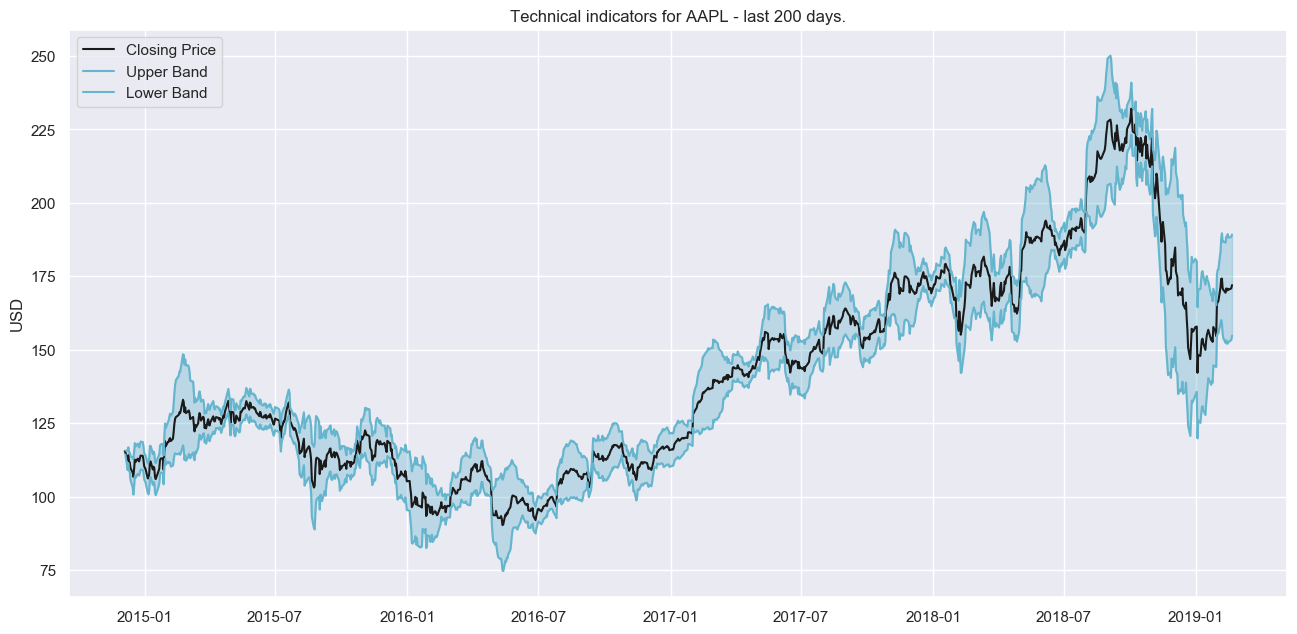

In [934]:
symbol = 'AAPL'

x_ = range(3, X.shape[0])
x_ = list(X.index)

last_days = 200
n = 30
#plt.fill_between()
plt.figure(figsize=(14, 7), dpi=100)
#plt.plot(dataset['ma7'], label='MA 7', color='g',linestyle='--')
plt.plot(djia[symbol]['Close'][:-last_days], label='Closing Price', color='k')
#plt.plot(X[symbol+'_macd1'],label='MACD 12, 26', color='r',linestyle='--')
plt.plot(X[f'{symbol}_bbu_{n}'][:-last_days], label='Upper Band', color='c')
plt.plot(X[f'{symbol}_bbl_{n}'][:-last_days], label='Lower Band', color='c')
plt.fill_between(X.index[:-last_days], X[f'{symbol}_bbu_{n}'][:-last_days], X[f'{symbol}_bbl_{n}'][:-last_days], color='c', alpha=0.35)
plt.title(f'Technical indicators for {symbol} - last {last_days} days.')
plt.ylabel('USD')
plt.legend()

In [476]:
#sns.pairplot(X.fillna(0))

In [477]:
X.fillna(0, inplace=True)

In [996]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
fname1 = data_base_dir + '/processed/djia_features_2019-12-19.pkl'
pickle.dump(X , open(fname1, 'wb'))

fname2 = data_base_dir + '/processed/djia_target_y_2c_2019-12-19.pkl'
pickle.dump(y_3c, open(fname2, 'wb'))

fname3 = data_base_dir + '/processed/djia_target_y_3c_2019-12-19.pkl'
pickle.dump(y_3c, open(fname3, 'wb'))

In [939]:
import pandas_datareader.famafrench
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portfolios_ME_OP_5x5_Wout_Div',
 '25_Portfolios_ME_OP_5x5_daily',
 '100_Po

In [942]:
from pandas_datareader.famafrench import FamaFrenchReader

In [943]:
ffr = FamaFrenchReader(['AAPL'])

In [949]:
import pandas_datareader as web

In [950]:
ds = web.DataReader('5_Industry_Portfolios', 'famafrench')


In [957]:
print(ds['DESCR'])

5 Industry Portfolios
---------------------

This file was created by CMPT_IND_RETS using the 201910 CRSP database. It contains value- and equal-weighted returns for 5 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2019 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (59 rows x 5 cols)
  1 : Average Equal Weighted Returns -- Monthly (59 rows x 5 cols)
  2 : Average Value Weighted Returns -- Annual (5 rows x 5 cols)
  3 : Average Equal Weighted Returns -- Annual (5 rows x 5 cols)
  4 : Number of Firms in Portfolios (59 rows x 5 cols)
  5 : Average Firm Size (59 rows x 5 cols)
  6 : Sum of BE / Sum of ME (6 rows x 5 cols)
  7 : Value-Weighted Average of BE/ME (6 rows x 5 cols)


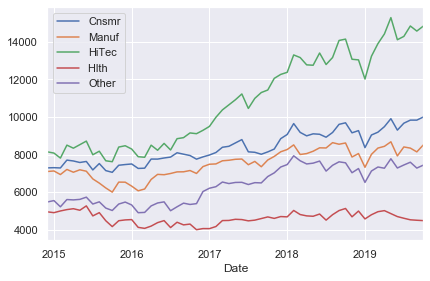

In [960]:
ds[5].plot()

In [961]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()


In [966]:
symbols.loc['AAPL']

Nasdaq Traded                            True
Security Name       Apple Inc. - Common Stock
Listing Exchange                            Q
Market Category                             Q
ETF                                     False
Round Lot Size                            100
Test Issue                              False
Financial Status                            N
CQS Symbol                                NaN
NASDAQ Symbol                            AAPL
NextShares                              False
Name: AAPL, dtype: object

In [977]:
f = web.DataReader('^SPX', 'stooq')

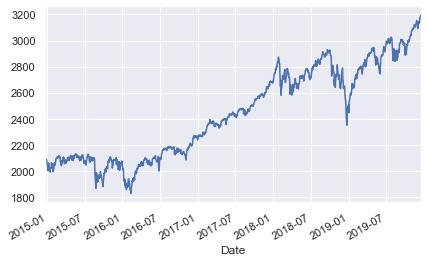

In [978]:
f['Close'].plot()

In [986]:
from pathlib import Path


In [982]:
DATA_STORE = Path('test.h5')
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', X.sort_index())
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: test.h5
/engineered_features            frame        (shape->[1259,96])


In [993]:
%%timeit -o
with pd.HDFStore(DATA_STORE) as store:
    df = store.get('engineered_features')


7.51 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 7.51 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [994]:
_

<TimeitResult : 7.51 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>